# Weather in Australia - Team 7

This cell just loads all used moduls for running the notebook. Please install any package if you dont have it installed in your environment so far.

In [1]:
#disable some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
#----------------------------#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
#plots the figures in place instead of a new window
%matplotlib inline

import ipywidgets as widgets


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import decomposition
from ipywidgets import interact, interactive, fixed, interact_manual
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from IPython.display import display, clear_output


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# Dataset Overview

We chose the rain in Australia dataset from Kaggle because we thought that it could be interesting to analyze a dataset with around 145000 rows. It is also interesting that data from about 10 years of daily observations from different locations throughout Australia has been collected.

Besides several numerical attributes, also several categorical attributes are provided. The attributes of the used dataset are explained below.

<ol>
    <li> Date: The observation's date
    <li> Location: The location of the observation
    <li> MinTemp: The minimum temperature on that day (°C)
    <li> MaxTemp: The maximum temperature on that day (°C)
    <li> Rainfall: The rainfall amount measured in mm
    <li> Evaporation: The evaporation also measured in mm
    <li> Sunshine: The number of sunshine hours
    <li> WindGustDir: The strongest wind gust's direction
    <li> WindGustSpeed: The strongest wind gust's speed in km/h
    <li> WindDir9am: The wind's direction at 9 AM
    <li> WindDir3pm: The wind's direction at 3 PM
    <li> WindSpeed9am: The wind's speed (km/h) at 9 AM
    <li> WindSpeed3pm: The wind's speed (km/h) at 3 PM
    <li> Humidity9am: The humidity percentage at 9 AM
    <li> Humidity3pm: The humidity percentage at 3 PM
    <li> Pressure9am: The atmospheric pressure (hpa) at 9 AM
    <li> Pressure3pm: The atmospheric pressure (hpa) at 3 PM
    <li> Cloud9am: Fraction of obscured sky by clouds (in "oktas") at 9 AM
    <li> Cloud3pm: Same as above but at 3 PM
    <li> Temp9am: Temperature in °C at 9 AM
    <li> Temp3pm: Temperature in °C at 3 PM
    <li> RainToday: True, if it has been raining on that day, otherwise False
    <li> RainTomorrow: True, if it has been raining on the next day, otherwise False; target variable
<ol>

In [2]:
# use the weather dataset of heterogenous data and plot first 5 lines
weather = pd.read_csv('data/weatherAUS.csv')
weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# overview of the created datatypes
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

# Data Preparation - Adjust Date Values

In this step, the data gets adjusted, in order to fit for our analysis.
This adjustments go especially for the Date in the first place. Here the whole Date value gets split up into a new year month and day column, in order to better aggregate over the set.

In [4]:
# Convert Date to a date type and create new columns
weather['Date_converted'] = pd.to_datetime(weather['Date'], format='%Y-%m-%d')
weather['Year'] = weather['Date_converted'].dt.year
weather['Month'] = weather['Date_converted'].dt.month
weather['Day'] = weather['Date_converted'].dt.day

# Overview of missing values

In order to to a proper data cleaning and having a feeling, how many values are even missing, we analysed the amount of missing data per column. It can be seen that for some columns nearly half of the values (40 - 48%) are missing (shown in the table as well as the plot above).

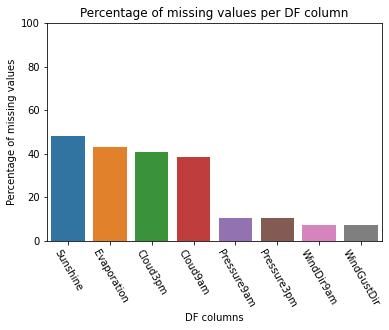

In [5]:
# Calculate percentage of null values per attribute
missing_in_percentage = weather.isnull().sum() * 100 / len(weather)
missing = pd.DataFrame({'col': weather.columns, 'missing_percent': missing_in_percentage})
missing.sort_values('missing_percent', inplace=True, ascending=False)

ax = sns.barplot(x="col", y="missing_percent", data=missing.head(8))
ax.set_ylim((0, 100))
ax.set_xticklabels(ax.get_xticklabels(), rotation=300)
ax.set_title('Percentage of missing values per DF column')
ax.set_xlabel('DF columns')
_ = ax.set_ylabel('Percentage of missing values')

# Base for missing values

## Missing values in different seasons

Now we further investigate this issue by looking at the columns sunshine, evaporation, cloud3pm and cloud9am by grouping the percentage of missing values first by season, to look whether we can see a seasonal affect. We also group the percentage of missing values by location to see if we can spot a locational affect. But as you can also see in the table below, there is no real trend, if the values tend to be not recorded in a specific season.

In [6]:
# Mapping the dates to seasons and calculate for each season and attribute the percentage of missing values.
seasons = {
   1: 'Winter',
   2: 'Spring',
   3: 'Summer',
   4: 'Autumn'
}
df_values_season = weather[['Year', 'Month', 'Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']].copy()

df_values_season['Season'] = (df_values_season['Month'] % 12 + 3) // 3
df_values_season['Season_name'] = df_values_season['Season'].map(seasons)

df_season_count_null = df_values_season[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']].isnull().groupby(df_values_season['Season_name']).sum()
df_season_count_all = df_values_season[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']].isnull().groupby(df_values_season['Season_name']).count()

df_missing_values_percent = (df_season_count_null / df_season_count_all) * 100
df_missing_values_percent['Season'] = df_missing_values_percent.index.tolist()
df_missing_values_percent.style.hide_index()

Sunshine,Evaporation,Cloud3pm,Cloud9am,Season
47.395082,42.394657,40.996689,38.537510,Autumn
48.680222,43.780054,41.022894,38.830232,Spring
48.109535,42.861420,38.639519,36.793968,Summer
47.793406,43.593759,42.648482,39.562098,Winter


## Missing values in different locations

As it can be seen, for 22 of the 49 locations no values are tracked which explains the large amount of missing data for the attributes 'Sunshine', 'Evaporation', 'Cloud3pm' and 'Cloud9am'. The reason for this is, however, unknown.

In [7]:
df_values_location = weather[['Location', 'Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']]
df_values_location_count_null = weather[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']].isnull().groupby(weather['Location']).sum()
# fillna is needed in order to get the 
df_values_location_count_all = weather[['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']].isnull().groupby(weather['Location']).count()

df_missing_values_percent = (df_values_location_count_null / df_values_location_count_all) * 100
df_missing_values_percent['Location'] = df_missing_values_percent.index.tolist()
mask = (df_missing_values_percent == 100.).any(axis=1)
print(f'Untracked values based on location: {df_missing_values_percent[mask].shape[0]} of {df_missing_values_percent.shape[0]}')

Untracked values based on location: 22 of 49


# Remove missing values

Since we can not clearly 'clean' missing values in any case, because we dont have information about the geo coordinates and also no mapping of close location, we simply drop these values. Still - 112925 samples are present 

In [8]:
weather.drop(['Date','Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am'],axis=1,inplace=True)

In [9]:
weather.dropna(inplace=True)
print(f'Amount of samples without missing values in any column: {weather.shape[0]}')
weather.head()

Amount of samples without missing values in any column: 112925


,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_converted,Year,Month,Day
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,...,1007.7,1007.1,16.9,21.8,No,No,2008-12-01,2008,12,1
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,...,1010.6,1007.8,17.2,24.3,No,No,2008-12-02,2008,12,2
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,...,1007.6,1008.7,21.0,23.2,No,No,2008-12-03,2008,12,3
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,...,1017.6,1012.8,18.1,26.5,No,No,2008-12-04,2008,12,4
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,...,1010.8,1006.0,17.8,29.7,No,No,2008-12-05,2008,12,5


# Check for valid values in all remaining (numeric) columns

In the next step, # check for minimum and maximum values in numeric attributes (in our case all attributes in the frame which have the datatype of float64. Here no out of range values could be detected. 

Attribute MinTemp:
Min: -8.20, Q1: 8.10, Median 12.40, Q3: 17.20, Max: 33.90


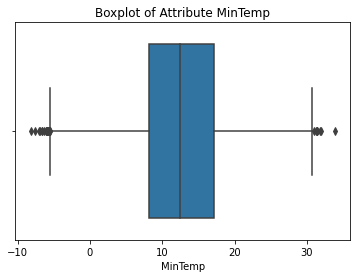

Attribute MaxTemp:
Min: 2.60, Q1: 18.30, Median 23.10, Q3: 28.70, Max: 48.10


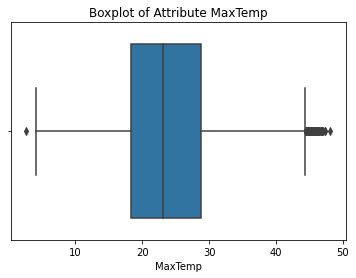

Attribute Rainfall:
Min: 0.00, Q1: 0.00, Median 0.00, Q3: 0.80, Max: 367.60


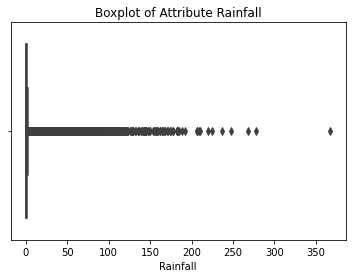

Attribute WindGustSpeed:
Min: 7.00, Q1: 31.00, Median 39.00, Q3: 48.00, Max: 135.00


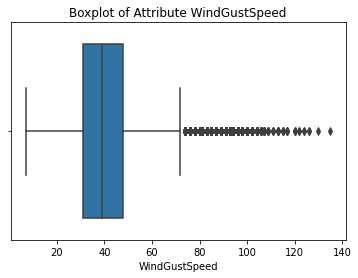

Attribute WindSpeed9am:
Min: 2.00, Q1: 9.00, Median 13.00, Q3: 20.00, Max: 87.00


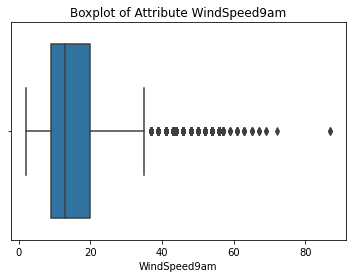

Attribute WindSpeed3pm:
Min: 2.00, Q1: 13.00, Median 19.00, Q3: 24.00, Max: 87.00


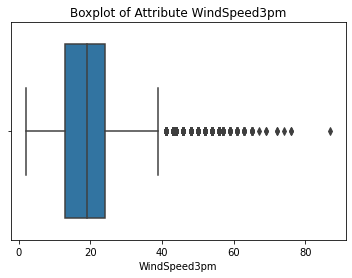

Attribute Humidity9am:
Min: 0.00, Q1: 56.00, Median 68.00, Q3: 81.00, Max: 100.00


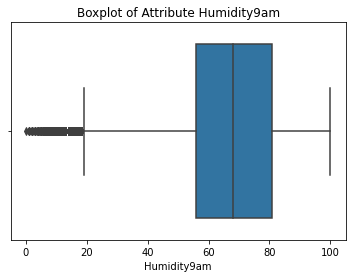

Attribute Humidity3pm:
Min: 0.00, Q1: 36.00, Median 51.00, Q3: 65.00, Max: 100.00


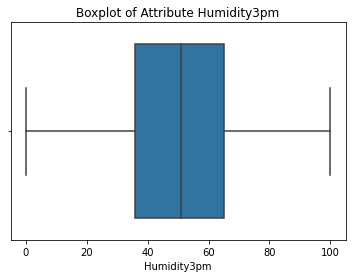

Attribute Pressure9am:
Min: 980.50, Q1: 1012.80, Median 1017.40, Q3: 1022.10, Max: 1041.00


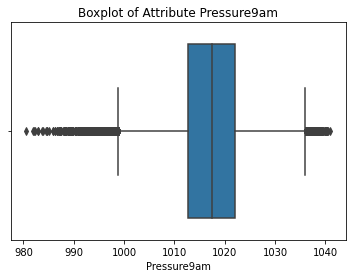

Attribute Pressure3pm:
Min: 977.10, Q1: 1010.30, Median 1015.00, Q3: 1019.70, Max: 1039.60


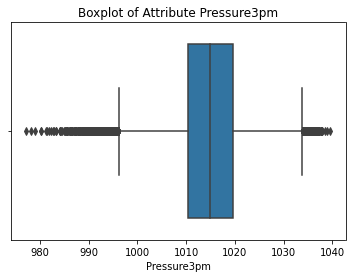

Attribute Temp9am:
Min: -3.10, Q1: 12.70, Median 17.10, Q3: 22.00, Max: 40.20


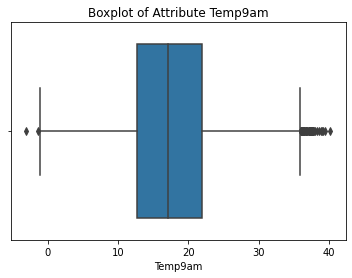

Attribute Temp3pm:
Min: 1.70, Q1: 16.90, Median 21.60, Q3: 26.90, Max: 46.70


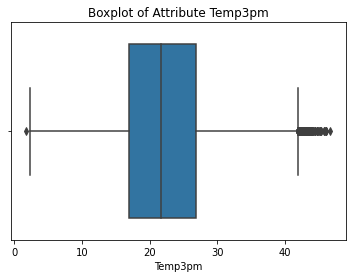

In [10]:
# check for minimum and maximum values in numeric attributes:
for col in weather.loc[:, weather.dtypes == 'float64']:
    print(f'Attribute {col}:')
    print("Min: {:.2f}, Q1: {:.2f}, Median {:.2f}, Q3: {:.2f}, Max: {:.2f}".format(weather[col].min(),weather[col].quantile(.25),weather[col].median(),weather[col].quantile(.75), weather[col].max()))
    sns.boxplot(x=weather[col])
    plt.title(f'Boxplot of Attribute {col}')
    plt.show()

# Check the distribution of RainTomorrow samples

As we can clearly see in the next cell, there are a lot more samples of NOT-raining tomorrow, as samples WITH raining tomorrow

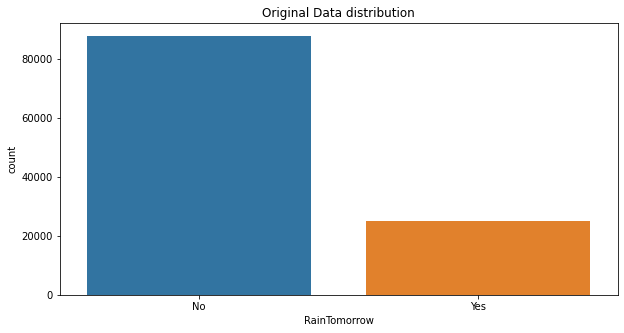

In [11]:
plt.figure(figsize=(10,5))
sns.countplot(x="RainTomorrow", data=weather);
plt.title('Original Data distribution')
plt.show()

In [12]:
# Disproportionate sampling:
# randomly select 4 samples from each stratum
stratified = weather.groupby('RainTomorrow', group_keys=False).apply(lambda x: x.sample(25000))

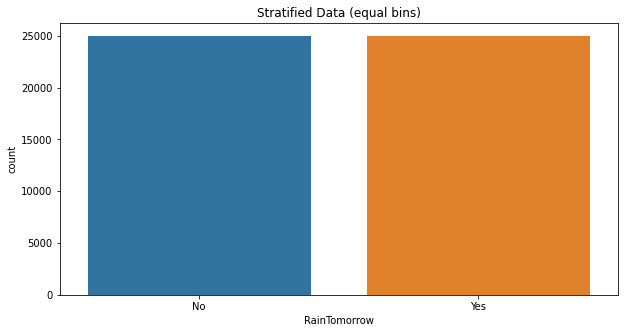

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(x="RainTomorrow", data=stratified)
plt.title("Stratified Data (equal bins)")
plt.show()

# PCA to explore the underlying structure of the data

In [14]:
stratified.drop('Date_converted',axis=1,inplace=True)
for col in stratified.loc[:, stratified.dtypes == object]:
    # creating instance of labelencoder
    labelencoder = LabelEncoder()
    # Assigning numerical values and storing in another column
    stratified[f'{col}_num'] = labelencoder.fit_transform(stratified[col])
    # drop non-numeric column
    stratified.drop(col,axis=1,inplace=True)

In [15]:
stratified.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,Temp3pm,Year,Month,Day,Location_num,WindGustDir_num,WindDir9am_num,WindDir3pm_num,RainToday_num,RainTomorrow_num
143984,11.9,21.5,0.0,43.0,24.0,24.0,78.0,34.0,1019.0,1017.6,...,21.0,2013,6,11,36,8,8,11,0,0
103614,13.0,27.4,0.0,41.0,22.0,13.0,67.0,12.0,1017.9,1014.9,...,25.9,2011,12,28,25,10,9,9,0,0
123190,13.1,31.5,0.0,39.0,17.0,17.0,27.0,41.0,1019.3,1018.0,...,24.7,2015,9,24,27,5,5,13,0,0
107223,13.2,21.9,0.0,59.0,33.0,19.0,44.0,21.0,1018.9,1019.6,...,19.6,2013,10,17,43,12,11,11,0,0
108158,11.9,20.4,0.0,81.0,41.0,52.0,75.0,49.0,1003.9,1006.3,...,19.3,2016,5,9,43,13,14,13,0,0


In [16]:
n_components = 7

pca = decomposition.PCA(n_components=n_components)
pca_pos = pca.fit_transform(stratified)

stratified['pca1']= pca_pos[:, 0]
stratified['pca2']= pca_pos[:, 1]

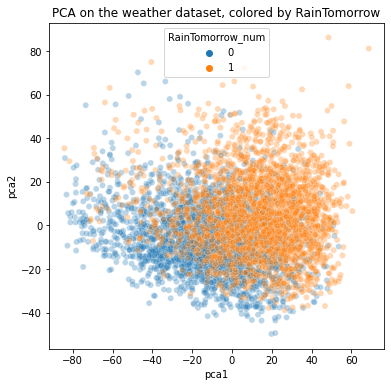

In [17]:
plt.figure(figsize=(6,6))
reducedPoints = stratified.groupby('RainTomorrow_num', group_keys=False).apply(lambda x: x.sample(2500))
sns.scatterplot(data=reducedPoints, x="pca1", y="pca2", hue="RainTomorrow_num",alpha=0.3)
plt.title('PCA on the weather dataset, colored by RainTomorrow')
plt.show()

# Decision Tree

In this section, we try to fit a Decision Tree classifier to our data. Therefore we do a GridSearch, where we try different criterions, maximum depths of the tree and splitting methods. The trained classifier also gets evaluated on 15% of the total data afterwards.

To keep the dataset clean, we removed all additional added attributes, we used in the previous section due to have more comfort. This does not change the actual data at all.

Note, that the data is also stratified like in the PCA above, so all classes are evenly distributed (standard would be to have a much higher amount of samples in the RainTomorrow=No comapred to RainTomorrow=Yes)

After creating the training and test sets, training and evaluating using a confusion matrix and accuracy as a score, we also provided an overview of the feature importance learned by the decision tree.

In [18]:
"""
Evaluates the model and returns accuracy as well as a confusion matrix. Also the time for prediction can is calculated.
@param model, sklearn model,trained model
@param x_test, np ndarray, data matrix
@param y_test, np ndarray, data vector
"""
def get_evaluation(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_mat = confusion_matrix(y_test, y_pred)

    print('\nPredicted Values: ', y_pred)
    print('\nAccuracy of Classifier on Test Image Data: ', accuracy)
    print('\nConfusion Matrix: \n', conf_mat)

    plt.matshow(conf_mat)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return None

In [24]:
param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': range(1,20),
    'splitter': ['random', 'best']
}

"""
Trains a random forest using cross-validation and returns certain attributes of the received model including the best
parameter combination.
@param x_train, np ndarray, data matrix
@param y_train, np ndarray, data vector
@param param_grid, dict, grid holding the paramaters for search
"""
def train_dec_tree(x_train,y_train,param_grid):
    tree = DecisionTreeClassifier(random_state=55)
    model = GridSearchCV(tree,param_grid=param_grid)
    model.fit(x_train,y_train)
    return model.best_params_,model.best_estimator_

In [23]:
# remove target value and addtional added columns
X = stratified.drop(['RainTomorrow_num','pca1','pca2'], axis=1)
y = stratified['RainTomorrow_num']
print(X.shape)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2)
X.head()

(50000, 20)


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Year,Month,Day,Location_num,WindGustDir_num,WindDir9am_num,WindDir3pm_num,RainToday_num
143984,11.9,21.5,0.0,43.0,24.0,24.0,78.0,34.0,1019.0,1017.6,16.2,21.0,2013,6,11,36,8,8,11,0
103614,13.0,27.4,0.0,41.0,22.0,13.0,67.0,12.0,1017.9,1014.9,16.5,25.9,2011,12,28,25,10,9,9,0
123190,13.1,31.5,0.0,39.0,17.0,17.0,27.0,41.0,1019.3,1018.0,23.6,24.7,2015,9,24,27,5,5,13,0
107223,13.2,21.9,0.0,59.0,33.0,19.0,44.0,21.0,1018.9,1019.6,13.8,19.6,2013,10,17,43,12,11,11,0
108158,11.9,20.4,0.0,81.0,41.0,52.0,75.0,49.0,1003.9,1006.3,15.1,19.3,2016,5,9,43,13,14,13,0



Predicted Values:  [0 1 1 ... 1 1 1]

Accuracy of Classifier on Test Image Data:  0.7793333333333333

Confusion Matrix: 
 [[2976  818]
 [ 837 2869]]
The best parameters are: {'criterion': 'entropy', 'max_depth': 8, 'splitter': 'best'}


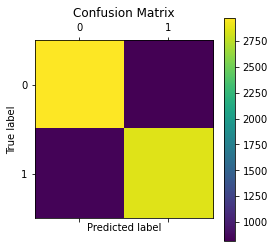

In [25]:
# train decision tree with created training set and evaluate on created target set
params_dec_tree, model_dec_tree = train_dec_tree(x_train, y_train, param_grid)
_ = get_evaluation(model_dec_tree, x_test, y_test)
print("The best parameters are: {}".format(params_dec_tree))

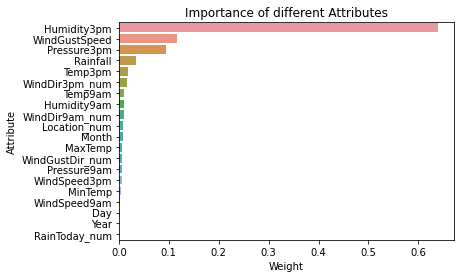

In [26]:
# create overview of feature importance, of learned decision tree
attribute_weights = pd.DataFrame({
    'Attribute' : x_train.columns,
    'Weight' : model_dec_tree.feature_importances_
}).sort_values(by='Weight', ascending=False)
plt.title('Importance of different Attributes')
sns.barplot(data = attribute_weights, x='Weight', y='Attribute');